#IMPORTS

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import numpy as np
from tensorflow.keras import datasets, layers, models
import numpy as np
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, f1_score, roc_auc_score, average_precision_score
from sklearn.metrics import confusion_matrix
import os
import cv2
from sklearn.metrics import recall_score
from keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import shuffle
from tensorflow.keras.regularizers import l2  # הוסף שורה זו
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import KFold
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import AdamW
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay



#COMMON FUNCTION

In [2]:
model_name = "VGG16"
IMG_SIZE=224

In [3]:
def show_confusin_matrix(cm):
  class_names = ['class 1', 'class 2', 'class 3']  # Replace with your class names
  #cm = confusion_matrix(y_test, y_pred)
  sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.title('Confusion Matrix '+model_name)
  plt.savefig(root_folder + model_name + "_cm.png", format='png')
  plt.show()






In [4]:
def show_plt(x1,x2,titlex1,titlex2,plot_title):
  # Plot the average training and validation loss
  plt.figure(figsize=(10, 6))
  plt.plot(x1, label=titlex1)
  plt.plot(x2, label=titlex2)
  plt.xlabel(titlex1)
  plt.ylabel(titlex2)
  plt.title(plot_title)
  plt.legend()
  plt.grid(True)
  plt.savefig(root_folder + model_name+"_" + plot_title+".png", format='png')
  plt.show()

In [5]:

def plot_training_validation(history):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # גרף דיוק
    ax1.plot(history.history['accuracy'], label='Train')
    #ax1.plot(history.history['val_accuracy'], label='Test')
    ax1.set_title('Accuracy model ' + model_name)
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend()

    # גרף אובדן
    ax2.plot(history.history['loss'], label='Train')
    #ax2.plot(history.history['val_loss'], label='Test')
    ax2.set_title('Loss model ' + model_name)
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend()
    plt.savefig(root_folder + model_name+"_AccAndLoss" + ".png", format='png')

    plt.tight_layout()
    plt.show()

def plot_training_validation(history):

    # גרף דיוק
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')

    # גרף הפסד
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

In [6]:
def plot_loss(train_losses,val_losses,k):
  # Plotting
  plt.figure(figsize=(12, 6))

  # Plot train losses
  for i in range(k):
      plt.plot(train_losses[i], label=f'Train Loss Fold {i+1}')

  # Plot validation losses
  for i in range(k):
      plt.plot(val_losses[i], label=f'Validation Loss Fold {i+1}', linestyle='--')

  plt.title('Loss Function Across K-Folds')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.savefig(root_folder + model_name + "_Loss.png", format='png')
  plt.show()

In [17]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np

def evaluate_model(model, X, y, metric='accuracy'):

    # Predict on the val data
    y_val_pred_prob = model.predict(np.array(X))

    # המרת ההסתברויות לחיזויים סופיים
    y_val_pred = np.argmax(y_val_pred_prob, axis=1)
    y_val_true = np.argmax(y, axis=1)  # המרת y_val לחיזויים מספריים

    # חישוב מדדים על קבוצת הבדיקה
    val_accuracy = accuracy_score(y_val_true, y_val_pred)
    val_precision = precision_score(y_val_true, y_val_pred, average='weighted')
    val_recall = recall_score(y_val_true, y_val_pred, average='weighted')
    val_f1 = f1_score(y_val_true, y_val_pred, average='weighted')

    # Create a dictionary with all metrics
    metrics = {
        'accuracy': val_accuracy,
        'precision': val_precision,
        'recall': val_recall,
        'f1': val_f1

    }

    # Return the chosen metric as the primary value
    primary_metric = metrics[metric]

    return primary_metric, metrics


#LOAD DATA

In [8]:
from google.colab import drive
drive.mount('/content/gdrive')
root_folder = '/content/gdrive/MyDrive/XRAY_Project/'
train_dir = root_folder+'/data/'

Mounted at /content/gdrive


In [19]:
X_alldata = []
y_alldata = []

for folder in os.scandir(train_dir):
    if folder.is_dir():
        for entry in os.scandir(folder.path):
            if entry.is_file() and entry.name.endswith(('.png', '.jpg', '.jpeg')):
                img = cv2.imread(entry.path)  # קריאת תמונה
                #img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))  # שינוי גודל התמונה
                if img is None:
                  raise ValueError("לא ניתן לקרוא את התמונה")
                h, w = img.shape[:2]
                aspect = w / h
                if aspect > 1:
                    new_w = IMG_SIZE
                    new_h = int(new_w / aspect)
                else:
                    new_h = IMG_SIZE
                    new_w = int(new_h * aspect)
                resized = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_CUBIC)
                final_img = np.zeros((IMG_SIZE, IMG_SIZE,3), dtype=np.uint8)
                x_offset = (IMG_SIZE - new_w) // 2
                y_offset = (IMG_SIZE - new_h) // 2
                final_img[y_offset:y_offset+new_h, x_offset:x_offset+new_w] = resized
                lab = cv2.cvtColor(final_img, cv2.COLOR_BGR2LAB)
                l, a, b = cv2.split(lab)
                clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
                cl = clahe.apply(l)
                limg = cv2.merge((cl,a,b))
                final = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
                img = cv2.GaussianBlur(final, (5, 5), 0)
                img = preprocess_input(img)  # עיבוד קלט עם
                img = np.array(img, dtype='float32')  # Convert image to float32 type
                X_alldata.append(img)
                y_alldata.append(int(folder.name) - 1)  # שים את התווית המתאימה


x_all = np.array(X_alldata, dtype='float32')
y_all = np.array(y_alldata)


num_classes = len(set(y_all))  # מספר הקטגוריות
y_all = to_categorical(y_all, num_classes=num_classes)


test_size = 0.2
val_size = 0.2



x_temp, x_test, y_temp, y_test = train_test_split(x_all, y_all, test_size=test_size, stratify=y_all, random_state=42,shuffle=True)

x_train, x_valid, y_train, y_valid = train_test_split(x_temp, y_temp, test_size=val_size, stratify=y_temp, random_state=42,shuffle=True)

#K_FOLD

In [20]:
num_classes = 3
all_scores = []
val_losses = []
accuracies = []
train_losses = []
val_losses = []
his_val_losses=[]
fold_no = 1
best_score = float('-inf')
best_model = None

# חישוב משקולות הקלאסים
y_integers = np.argmax(y_train, axis=1)
class_weights = compute_class_weight('balanced', classes=np.unique(y_integers), y=y_integers)
class_weight_dict = dict(zip(np.unique(y_integers), class_weights))

# הגדרת StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


datagen = ImageDataGenerator(
    #rotation_range=20,
    width_shift_range=0.10,
    height_shift_range=0.10,
    zoom_range=0.10
)



# לולאת StratifiedKFold Cross Validation
for train_index, val_index in skf.split(x_train, y_integers):
    x_train_fold, x_val_fold = x_train[train_index], x_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # בניית המודל
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

    # קפיאה של השכבות הבסיסיות
    for layer in base_model.layers:
        layer.trainable = False

    # הוספת שכבות מותאמות אישית עם רגולריזציה

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.7)(x)
    predictions = Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.01))(x)

    # יצירת המודל המלא
    model = Model(inputs=base_model.input, outputs=predictions)

    # הגדרת callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
    early_stopping1 = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr1 = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
    # הידור המודל
    model.compile(AdamW(learning_rate=0.0001, weight_decay=0.01),#Adam(learning_rate=0.0001),#optimizer=SGD(learning_rate=0.01, momentum=0.9),#
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # אימון המודל על קפל האימון עם הגדלת נתונים ומשקולות
    train_generator = datagen.flow(x_train_fold, y_train_fold, batch_size=32)
    history = model.fit(train_generator,
                        epochs=50,  # הגדלנו את מספר האפוקות
                        validation_data=(x_val_fold, y_val_fold),
                        callbacks=[early_stopping, reduce_lr],
                        class_weight=class_weight_dict,
                        batch_size=16)

    # Fine-tuning: שחרור השכבות האחרונות לאימון מחדש
    for layer in model.layers[-20:]:
        layer.trainable = True

    # הידור מחדש של המודל
    model.compile(optimizer=Adam(learning_rate=0.00001),
                  loss='categorical_crossentropy',  metrics=['accuracy'])

    # Fine-tuning על קפל האימון עם משקולות
    history_fine_tune = model.fit(train_generator,
                                  epochs=50,  # הגדלנו את מספר האפוקות
                                  validation_data=(x_val_fold, y_val_fold),
                                  callbacks=[early_stopping1, reduce_lr1],
                                  class_weight=class_weight_dict,
                                  batch_size=16)

    # הערכת המודל על קבוצת הוולידציה
    val_loss, val_acc = model.evaluate(x_val_fold, y_val_fold, verbose=2)

    print(f'\nFold {fold_no} - Validation Accuracy: {val_acc * 100:.2f}%')
    print(f'\nFold {fold_no} - Validation Loss: {val_loss:.4f}')
    accuracies.append(val_acc)
    val_losses.append(val_loss)
    train_losses.append(history.history['loss'])
    his_val_losses.append(history.history['val_loss'])
    # Compute confusion matrix
    print(f'\nFold {fold_no} - Validation Accuracy: {val_acc * 100:.2f}%')
    print(f'\nFold {fold_no} - Validation Loss: {val_loss:.4f}')
    score, metrics = evaluate_model(model, x_val_fold, y_val_fold, metric='accuracy')

    print(f"Fold {fold_no} metrics: {metrics}")

    if score > best_score:
        best_score = score
        best_model = model
    fold_no += 1
print(f"Best model score: {best_score}")


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 469ms/step - accuracy: 0.3146 - loss: 10.9090 - val_accuracy: 0.3438 - val_loss: 8.2762 - learning_rate: 1.0000e-04
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 184ms/step - accuracy: 0.3583 - loss: 9.5239 - val_accuracy: 0.6562 - val_loss: 7.7017 - learning_rate: 1.0000e-04
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 191ms/step - accuracy: 0.4271 - loss: 9.6785 - val_accuracy: 0.7500 - val_loss: 7.5102 - learning_rate: 1.0000e-04
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 187ms/step - accuracy: 0.5271 - loss: 9.0638 - val_accuracy: 0.6875 - val_loss: 7.4313 - learning_rate: 1.0000e-04
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 196ms/step - accuracy: 0.5604 - loss: 8.5015 - val_accuracy: 0.7188 - val_loss: 7.3352 - learning_rate: 1.0000e-04
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 187ms/step - accuracy: 0.5656 - loss: 9.1264 - val_accuracy: 0.7500 - val_loss: 7.3002 - learning_rate: 1.0000e-04
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 186ms/step - accuracy: 0.6219 - loss: 8.2404 - 

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 464ms/step - accuracy: 0.3448 - loss: 10.3405 - val_accuracy: 0.5312 - val_loss: 7.7808 - learning_rate: 1.0000e-04
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 183ms/step - accuracy: 0.2688 - loss: 10.1857 - val_accuracy: 0.7812 - val_loss: 7.3893 - learning_rate: 1.0000e-04
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 192ms/step - accuracy: 0.4729 - loss: 9.4051 - val_accuracy: 0.8125 - val_loss: 7.2365 - learning_rate: 1.0000e-04
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 198ms/step - accuracy: 0.5396 - loss: 8.7550 - val_accuracy: 0.8438 - val_loss: 7.1388 - learning_rate: 1.0000e-04
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 186ms/step - accuracy: 0.5479 - loss: 8.6253 - val_accuracy: 0.8438 - val_loss: 7.1416 - learning_rate: 1.0000e-04
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 190ms/step - accuracy: 0.6365 - loss: 8.2963 - val_accuracy: 0.7812 - val_loss: 7.2737 - learning_rate: 1.0000e-04
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 181ms/step - accuracy: 0.5312 - loss: 8.3249 -

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step
Fold 2 metrics: {'accuracy': 0.9375, 'precision': 0.940625, 'recall': 0.9375, 'f1': 0.9377436647173489}
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 469ms/step - accuracy: 0.3385 - loss: 11.4189 - val_accuracy: 0.3750 - val_loss: 8.3557 - learning_rate: 1.0000e-04
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 191ms/step - accuracy: 0.4052 - loss: 9.6134 - val_accuracy: 0.4688 - val_loss: 7.9707 - learning_rate: 1.0000e-04
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 203ms/step - accuracy: 0.3938 - loss: 9.3884 - val_accuracy: 0.6250 - val_loss: 7.5247 - learning_rate: 1.0000e-04
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 184ms/step - accuracy: 0.4875 - loss: 9.1062 - val_accuracy: 0.8750 - val_loss: 7.1822 - learning_rate: 1.0000e-04
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 194ms/step - accuracy: 0.5448 - loss: 8.3639 - val_accuracy: 0.9062 - val_loss: 6.9965 - learning_rate: 1.0000e-04
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 204ms/step - accuracy: 0.5115 - loss: 8.6511 - val_accuracy: 0.9375 - val_loss: 6.8798 - learning_rate: 1.0000e-04
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 186ms/step - accuracy: 0.5510 - loss: 8.7586 - 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step
Fold 3 metrics: {'accuracy': 0.96875, 'precision': 0.971875, 'recall': 0.96875, 'f1': 0.9689936647173489}
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 678ms/step - accuracy: 0.2271 - loss: 12.2394 - val_accuracy: 0.2500 - val_loss: 9.0853 - learning_rate: 1.0000e-04
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 184ms/step - accuracy: 0.3313 - loss: 10.5372 - val_accuracy: 0.3125 - val_loss: 8.0010 - learning_rate: 1.0000e-04
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 183ms/step - accuracy: 0.4198 - loss: 9.5953 - val_accuracy: 0.5312 - val_loss: 7.8046 - learning_rate: 1.0000e-04
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 171ms/step - accuracy: 0.5302 - loss: 9.0683 - val_accuracy: 0.5000 - val_loss: 7.8549 - learning_rate: 1.0000e-04
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 183ms/step - accuracy: 0.4625 - loss: 8.8189 - val_accuracy: 0.5625 - val_loss: 7.6422 - learning_rate: 1.0000e-04
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 189ms/step - accuracy: 0.6427 - loss: 8.6762 - val_accuracy: 0.5938 - val_loss: 7.4878 - learning_rate: 1.0000e-04
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 197ms/step - accuracy: 0.5646 - loss: 8.4340 -

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 471ms/step - accuracy: 0.3375 - loss: 10.2929 - val_accuracy: 0.4688 - val_loss: 7.9643 - learning_rate: 1.0000e-04
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 181ms/step - accuracy: 0.3469 - loss: 9.5226 - val_accuracy: 0.6875 - val_loss: 7.4929 - learning_rate: 1.0000e-04
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 184ms/step - accuracy: 0.5083 - loss: 9.3563 - val_accuracy: 0.8438 - val_loss: 7.2360 - learning_rate: 1.0000e-04
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 190ms/step - accuracy: 0.4844 - loss: 9.8447 - val_accuracy: 0.9062 - val_loss: 7.0555 - learning_rate: 1.0000e-04
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 194ms/step - accuracy: 0.5323 - loss: 8.8755 - val_accuracy: 0.9062 - val_loss: 6.9433 - learning_rate: 1.0000e-04
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 195ms/step - accuracy: 0.5802 - loss: 8.4941 - val_accuracy: 0.9375 - val_loss: 6.8384 - learning_rate: 1.0000e-04
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 190ms/step - accuracy: 0.6271 - loss: 8.4785 - 

In [21]:
print(f"\nKFOLD Average Accuracy: {np.mean(accuracies):.4f}")


KFOLD Average Accuracy: 0.9313


In [ ]:

print(f"\nKFOLD Average Accuracy: {np.mean(accuracies):.4f}")



KFOLD Average Accuracy: 0.9313


In [22]:
model.save(root_folder+"vgg.keras")
best_model.save(root_folder+"vgg_best_model.keras")

#Evaluate Model

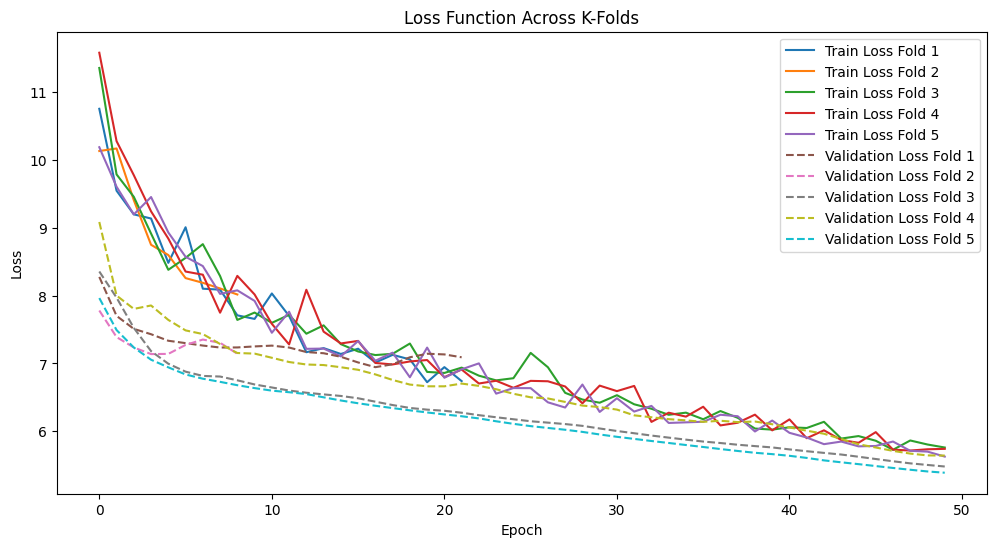

In [23]:
plot_loss(train_losses,his_val_losses,5)

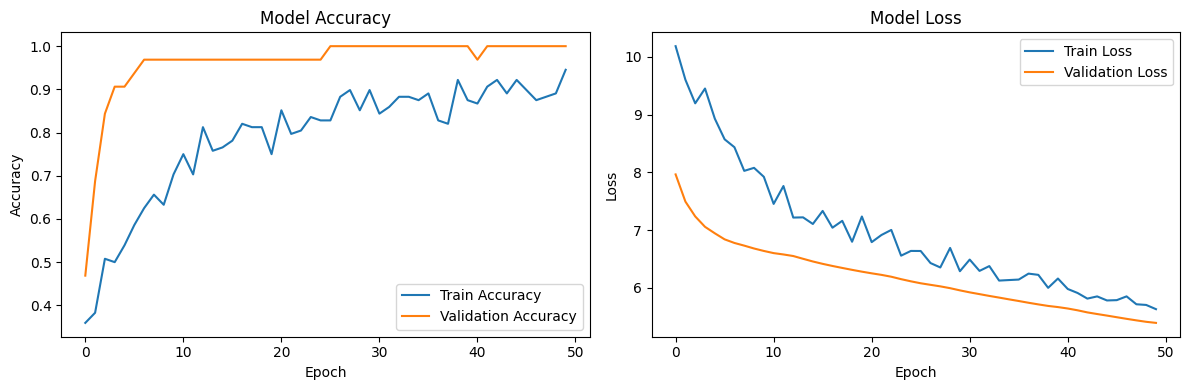

In [24]:
# הצגת גרף האימון והוולידציה
plot_training_validation(history)


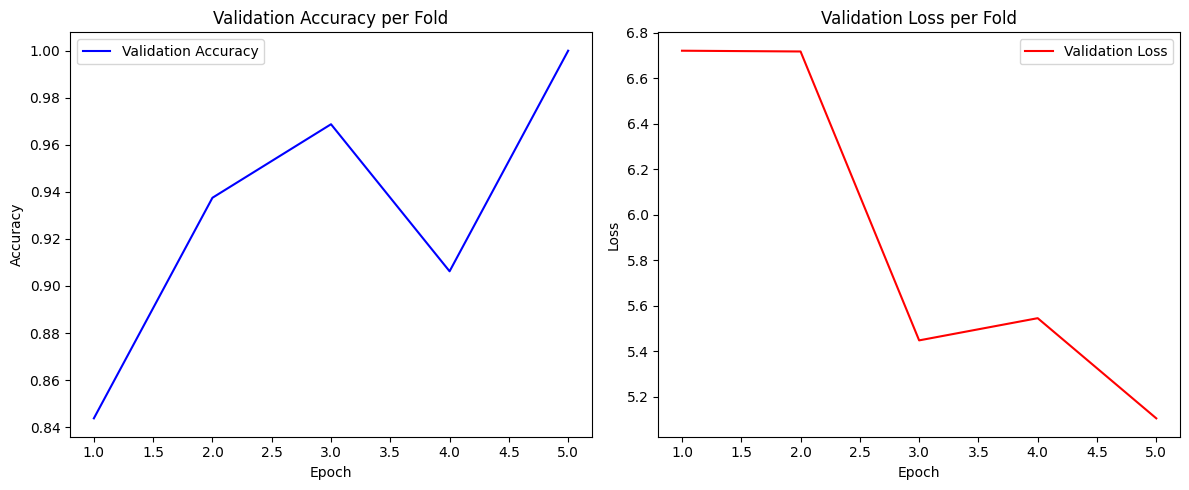

In [25]:
import matplotlib.pyplot as plt

# נניח שיש לנו רשימות של accuracies ו-val_losses


# יצירת טווח של אפוכות (epochs) - מספר האיטרציות
epochs = range(1, len(accuracies) + 1)

# יצירת הגרף
plt.figure(figsize=(12, 5))

# תת-גרף עבור accuracies
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracies, 'b-', label='Validation Accuracy')
plt.title('Validation Accuracy per Fold')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# תת-גרף עבור val_losses
plt.subplot(1, 2, 2)
plt.plot(epochs, val_losses, 'r-', label='Validation Loss')
plt.title('Validation Loss per Fold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# התאמת המרווחים בין תתי-הגרפים
plt.tight_layout()

# הצגת הגרף
plt.show()

#Model Results

##confusion_matrix

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


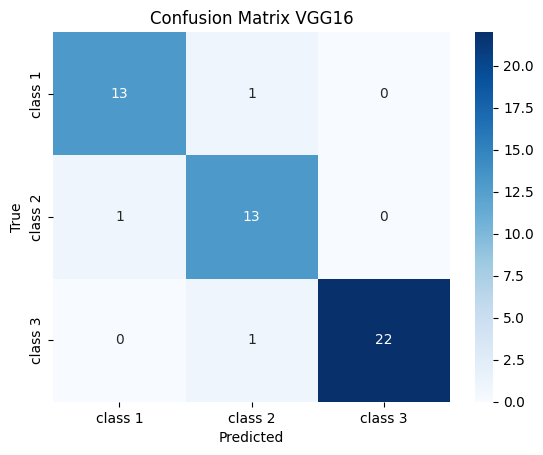

In [29]:

# חיזוי ההסתברויות על קבוצת הבדיקה
y_test_pred_prob = best_model.predict(np.array(x_test))

# המרת ההסתברויות לחיזויים סופיים
y_test_pred = np.argmax(y_test_pred_prob, axis=1)
y_test_true = np.argmax(y_test, axis=1)  # המרת y_test לחיזויים מספריים

# חישוב מדדים על קבוצת הבדיקה
test_accuracy = accuracy_score(y_test_true, y_test_pred)
test_precision = precision_score(y_test_true, y_test_pred, average='weighted')
test_recall = recall_score(y_test_true, y_test_pred, average='weighted')
test_f1 = f1_score(y_test_true, y_test_pred, average='weighted')
test_roc_auc = roc_auc_score(y_test, y_test_pred_prob, multi_class='ovr')
test_pr_auc = average_precision_score(y_test, y_test_pred_prob, average='weighted')
test_confusion_matrix = confusion_matrix(y_test_true, y_test_pred)

# הצגת מטריצת הבלבול
show_confusin_matrix(test_confusion_matrix)

##Accuracy, Precision, Recall, F1 Score

In [30]:

print(f"Test Set Results:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1 Score: {test_f1:.4f}")
print(f"ROC AUC: {test_roc_auc:.4f}")
print(f"PR AUC: {test_pr_auc:.4f}")
print(f"Confusion Matrix:\n{test_confusion_matrix}")

Test Set Results:
Accuracy: 0.9412
Precision: 0.9438
Recall: 0.9412
F1 Score: 0.9420
ROC AUC: 0.9878
PR AUC: 0.9807
Confusion Matrix:
[[13  1  0]
 [ 1 13  0]
 [ 0  1 22]]


##Classification Report

In [28]:
target_names = ['class 1', 'class 2', 'class 3']

# יצירת ה-Classification Report
report = classification_report(y_test_true, y_test_pred, target_names=target_names)

# הדפסת הדוח
print(report)

              precision    recall  f1-score   support

     class 1       0.93      0.93      0.93        14
     class 2       0.87      0.93      0.90        14
     class 3       1.00      0.96      0.98        23

    accuracy                           0.94        51
   macro avg       0.93      0.94      0.93        51
weighted avg       0.94      0.94      0.94        51



#Test Model
*****Define test directory*****

*****directory name as label (as we got 1,2,3)*****

In [ ]:
IMG_SIZE = 224

root_folder = '***'
model_path=root_folder+"vgg_best_model.keras"
test_dir = root_folder + 'test/'

In [ ]:
import os
import cv2
import numpy as np
from keras.applications.vgg16 import preprocess_input

X_testdata = []
y_testdata = []

for folder in os.scandir(test_dir):
    if folder.is_dir():
        for entry in os.scandir(folder.path):
            if entry.is_file() and entry.name.endswith(('.png', '.jpg', '.jpeg')):
                img = cv2.imread(entry.path)  # קריאת תמונה
                #img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))  # שינוי גודל התמונה
                if img is None:
                  raise ValueError("לא ניתן לקרוא את התמונה")

                # חישוב היחס לשמירה על פרופורציות
                h, w = img.shape[:2]
                aspect = w / h

                # קביעת הגודל החדש תוך שמירה על היחס
                if aspect > 1:
                    # תמונה רחבה יותר
                    new_w = IMG_SIZE
                    new_h = int(new_w / aspect)
                else:
                    # תמונה גבוהה יותר
                    new_h = IMG_SIZE
                    new_w = int(new_h * aspect)

                # ביצוע ה-resize
                resized = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_CUBIC)

                # יצירת תמונה ריקה בגודל היעד
                final_img = np.zeros((IMG_SIZE, IMG_SIZE,3), dtype=np.uint8)

                # מיקום התמונה שעברה resize במרכז
                x_offset = (IMG_SIZE - new_w) // 2
                y_offset = (IMG_SIZE - new_h) // 2
                final_img[y_offset:y_offset+new_h, x_offset:x_offset+new_w] = resized

                final_img = cv2.GaussianBlur(final_img, (5, 5), 0)

                img = preprocess_input(final_img)  # עיבוד קלט עם

                img = np.array(img, dtype='float32')  # Convert image to float32 type

                X_testdata.append(img)
                y_testdata.append(int(folder.name) - 1)  # שים את התווית המתאימה

# המרת נתונים למערכים numpy
x_all_test = np.array(X_testdata, dtype='float32')
y_all_test = np.array(y_testdata)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score, confusion_matrix

# חיזוי ההסתברויות על קבוצת הבדיקה
y_test_pred_prob = best_model.predict(np.array(x_all_test))

# המרת ההסתברויות לחיזויים סופיים
y_test_pred = np.argmax(y_test_pred_prob, axis=1)
y_test_true = y_all_test#np.argmax(, axis=1)  # המרת y_test לחיזויים מספריים

# חישוב מדדים על קבוצת הבדיקה
test_accuracy = accuracy_score(y_test_true, y_test_pred)
test_precision = precision_score(y_test_true, y_test_pred, average='weighted')
test_recall = recall_score(y_test_true, y_test_pred, average='weighted')
test_f1 = f1_score(y_test_true, y_test_pred, average='weighted')
test_roc_auc = roc_auc_score(y_all_test, y_test_pred_prob, multi_class='ovr')
#test_pr_auc = average_precision_score(y_all, y_test_pred_prob, average='weighted')
test_confusion_matrix = confusion_matrix(y_test_true, y_test_pred)

# הדפסת המדדים
print(f"Test Set Results:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1 Score: {test_f1:.4f}")
print(f"ROC AUC: {test_roc_auc:.4f}")
#print(f"PR AUC: {test_pr_auc:.4f}")
print(f"Confusion Matrix:\n{test_confusion_matrix}")

#ExplainAble AI

In [ ]:
%pip install tf-keras-vis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 4.9 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
root_folder = '/content/gdrive/MyDrive/XRAY_Project/'
train_dir = root_folder+'/data/'
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.applications.vgg16 import preprocess_input
IMG_SIZE = 224
def preprocess_image(img_path):
        img = cv2.imread(entry.path)  # קריאת תמונה
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))  # שינוי גודל התמונה
        rgb_image = cv2.merge([img, img, img])  # שינוי התמונה לצבע
        rgb_image = preprocess_input(rgb_image)

        #img = np.array(rgb_image, dtype='float32')
        #array = np.expand_dims(img, axis=0)
        return rgb_image

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import os
import random
from PIL import Image
from tensorflow import keras

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm
model_builder = keras.applications.xception.Xception
img_size = (224, 224)
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions

In [ ]:
from tensorflow.keras.models import load_model

model = load_model('/content/gdrive/MyDrive/XRAY_Project/vgg_best_model.keras')
model.summary()

TypeError: Could not deserialize class 'Functional' because its parent module keras.src.engine.functional cannot be imported. Full object config: {'module': 'keras.src.engine.functional', 'class_name': 'Functional', 'config': {'name': 'model', 'trainable': True, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_input_shape': [None, 224, 224, 3], 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'input_1'}, 'registered_name': None, 'name': 'input_1', 'inbound_nodes': []}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block1_conv1', 'trainable': True, 'dtype': 'float32', 'filters': 64, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 224, 224, 3]}, 'name': 'block1_conv1', 'inbound_nodes': [[['input_1', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block1_conv2', 'trainable': True, 'dtype': 'float32', 'filters': 64, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 224, 224, 64]}, 'name': 'block1_conv2', 'inbound_nodes': [[['block1_conv1', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'MaxPooling2D', 'config': {'name': 'block1_pool', 'trainable': True, 'dtype': 'float32', 'pool_size': [2, 2], 'padding': 'valid', 'strides': [2, 2], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 224, 224, 64]}, 'name': 'block1_pool', 'inbound_nodes': [[['block1_conv2', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block2_conv1', 'trainable': True, 'dtype': 'float32', 'filters': 128, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 112, 112, 64]}, 'name': 'block2_conv1', 'inbound_nodes': [[['block1_pool', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block2_conv2', 'trainable': True, 'dtype': 'float32', 'filters': 128, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 112, 112, 128]}, 'name': 'block2_conv2', 'inbound_nodes': [[['block2_conv1', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'MaxPooling2D', 'config': {'name': 'block2_pool', 'trainable': True, 'dtype': 'float32', 'pool_size': [2, 2], 'padding': 'valid', 'strides': [2, 2], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 112, 112, 128]}, 'name': 'block2_pool', 'inbound_nodes': [[['block2_conv2', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block3_conv1', 'trainable': True, 'dtype': 'float32', 'filters': 256, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 128]}, 'name': 'block3_conv1', 'inbound_nodes': [[['block2_pool', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block3_conv2', 'trainable': True, 'dtype': 'float32', 'filters': 256, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 256]}, 'name': 'block3_conv2', 'inbound_nodes': [[['block3_conv1', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block3_conv3', 'trainable': True, 'dtype': 'float32', 'filters': 256, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 256]}, 'name': 'block3_conv3', 'inbound_nodes': [[['block3_conv2', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'MaxPooling2D', 'config': {'name': 'block3_pool', 'trainable': True, 'dtype': 'float32', 'pool_size': [2, 2], 'padding': 'valid', 'strides': [2, 2], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 256]}, 'name': 'block3_pool', 'inbound_nodes': [[['block3_conv3', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block4_conv1', 'trainable': True, 'dtype': 'float32', 'filters': 512, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 256]}, 'name': 'block4_conv1', 'inbound_nodes': [[['block3_pool', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block4_conv2', 'trainable': True, 'dtype': 'float32', 'filters': 512, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 512]}, 'name': 'block4_conv2', 'inbound_nodes': [[['block4_conv1', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block4_conv3', 'trainable': True, 'dtype': 'float32', 'filters': 512, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 512]}, 'name': 'block4_conv3', 'inbound_nodes': [[['block4_conv2', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'MaxPooling2D', 'config': {'name': 'block4_pool', 'trainable': True, 'dtype': 'float32', 'pool_size': [2, 2], 'padding': 'valid', 'strides': [2, 2], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 512]}, 'name': 'block4_pool', 'inbound_nodes': [[['block4_conv3', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block5_conv1', 'trainable': True, 'dtype': 'float32', 'filters': 512, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 512]}, 'name': 'block5_conv1', 'inbound_nodes': [[['block4_pool', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block5_conv2', 'trainable': True, 'dtype': 'float32', 'filters': 512, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 512]}, 'name': 'block5_conv2', 'inbound_nodes': [[['block5_conv1', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block5_conv3', 'trainable': True, 'dtype': 'float32', 'filters': 512, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 512]}, 'name': 'block5_conv3', 'inbound_nodes': [[['block5_conv2', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'MaxPooling2D', 'config': {'name': 'block5_pool', 'trainable': True, 'dtype': 'float32', 'pool_size': [2, 2], 'padding': 'valid', 'strides': [2, 2], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 512]}, 'name': 'block5_pool', 'inbound_nodes': [[['block5_conv3', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'GlobalAveragePooling2D', 'config': {'name': 'global_average_pooling2d', 'trainable': True, 'dtype': 'float32', 'data_format': 'channels_last', 'keepdims': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 512]}, 'name': 'global_average_pooling2d', 'inbound_nodes': [[['block5_pool', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense', 'trainable': True, 'dtype': 'float32', 'units': 1024, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 512]}, 'name': 'dense', 'inbound_nodes': [[['global_average_pooling2d', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_1', 'trainable': True, 'dtype': 'float32', 'units': 3, 'activation': 'softmax', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 1024]}, 'name': 'dense_1', 'inbound_nodes': [[['dense', 0, 0, {}]]]}], 'input_layers': [['input_1', 0, 0]], 'output_layers': [['dense_1', 0, 0]]}, 'registered_name': 'Functional', 'build_config': {'input_shape': [None, 224, 224, 3]}, 'compile_config': {'optimizer': {'module': 'keras.optimizers', 'class_name': 'Adam', 'config': {'name': 'Adam', 'weight_decay': None, 'clipnorm': None, 'global_clipnorm': None, 'clipvalue': None, 'use_ema': False, 'ema_momentum': 0.99, 'ema_overwrite_frequency': None, 'jit_compile': True, 'is_legacy_optimizer': False, 'learning_rate': 9.999999747378752e-06, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-07, 'amsgrad': False}, 'registered_name': None}, 'loss': 'categorical_crossentropy', 'metrics': ['accuracy'], 'loss_weights': None, 'weighted_metrics': None, 'run_eagerly': None, 'steps_per_execution': None, 'jit_compile': None}}

In [ ]:
last_conv_layer_name = "block5_conv3"
model.layers[-1].activation = None

In [ ]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img =preprocess_image(img_path)#keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    #img_array = np.expand_dims(img_array, axis=0)
    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        print("צורת preds:", preds.shape)

        # אם preds הוא טנזור 2D (batch_size, num_classes)
        if len(preds.shape) == 2:
            if pred_index is None:
                pred_index = tf.argmax(preds[0])
            class_channel = preds[0, pred_index]

        # אם preds הוא טנזור 1D (num_classes)
        elif len(preds.shape) == 1:
            if pred_index is None:
                pred_index = tf.argmax(preds)
            class_channel = preds[pred_index]

        else:
            raise ValueError(f"צורה לא צפויה של preds: {preds.shape}")

        print("pred_index:", pred_index)
        print("class_channel:", class_channel)
        print("predict:")
        print(preds[0])



    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

0 /content/gdrive/MyDrive/XRAY_Project//data//01/048.jpeg
צורת preds: (1, 3)
pred_index: tf.Tensor(0, shape=(), dtype=int64)
class_channel: tf.Tensor(7.0093517, shape=(), dtype=float32)
predict:
tf.Tensor([ 7.0093517  -0.03665737 -2.456327  ], shape=(3,), dtype=float32)


<ipython-input-49-4c399604bce7>:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


1 /content/gdrive/MyDrive/XRAY_Project//data//01/073.jpeg
צורת preds: (1, 3)
pred_index: tf.Tensor(0, shape=(), dtype=int64)
class_channel: tf.Tensor(6.9698954, shape=(), dtype=float32)
predict:
tf.Tensor([ 6.9698954  -4.527343    0.24869134], shape=(3,), dtype=float32)
2 /content/gdrive/MyDrive/XRAY_Project//data//01/057.jpeg
צורת preds: (1, 3)
pred_index: tf.Tensor(0, shape=(), dtype=int64)
class_channel: tf.Tensor(7.8348413, shape=(), dtype=float32)
predict:
tf.Tensor([ 7.8348413  -0.95556086 -2.7197475 ], shape=(3,), dtype=float32)
3 /content/gdrive/MyDrive/XRAY_Project//data//01/078.jpeg
צורת preds: (1, 3)
pred_index: tf.Tensor(0, shape=(), dtype=int64)
class_channel: tf.Tensor(3.9675143, shape=(), dtype=float32)
predict:
tf.Tensor([ 3.9675143  -1.1044341   0.22411583], shape=(3,), dtype=float32)
4 /content/gdrive/MyDrive/XRAY_Project//data//01/067.jpeg
צורת preds: (1, 3)
pred_index: tf.Tensor(0, shape=(), dtype=int64)
class_channel: tf.Tensor(6.3554378, shape=(), dtype=float32)
p

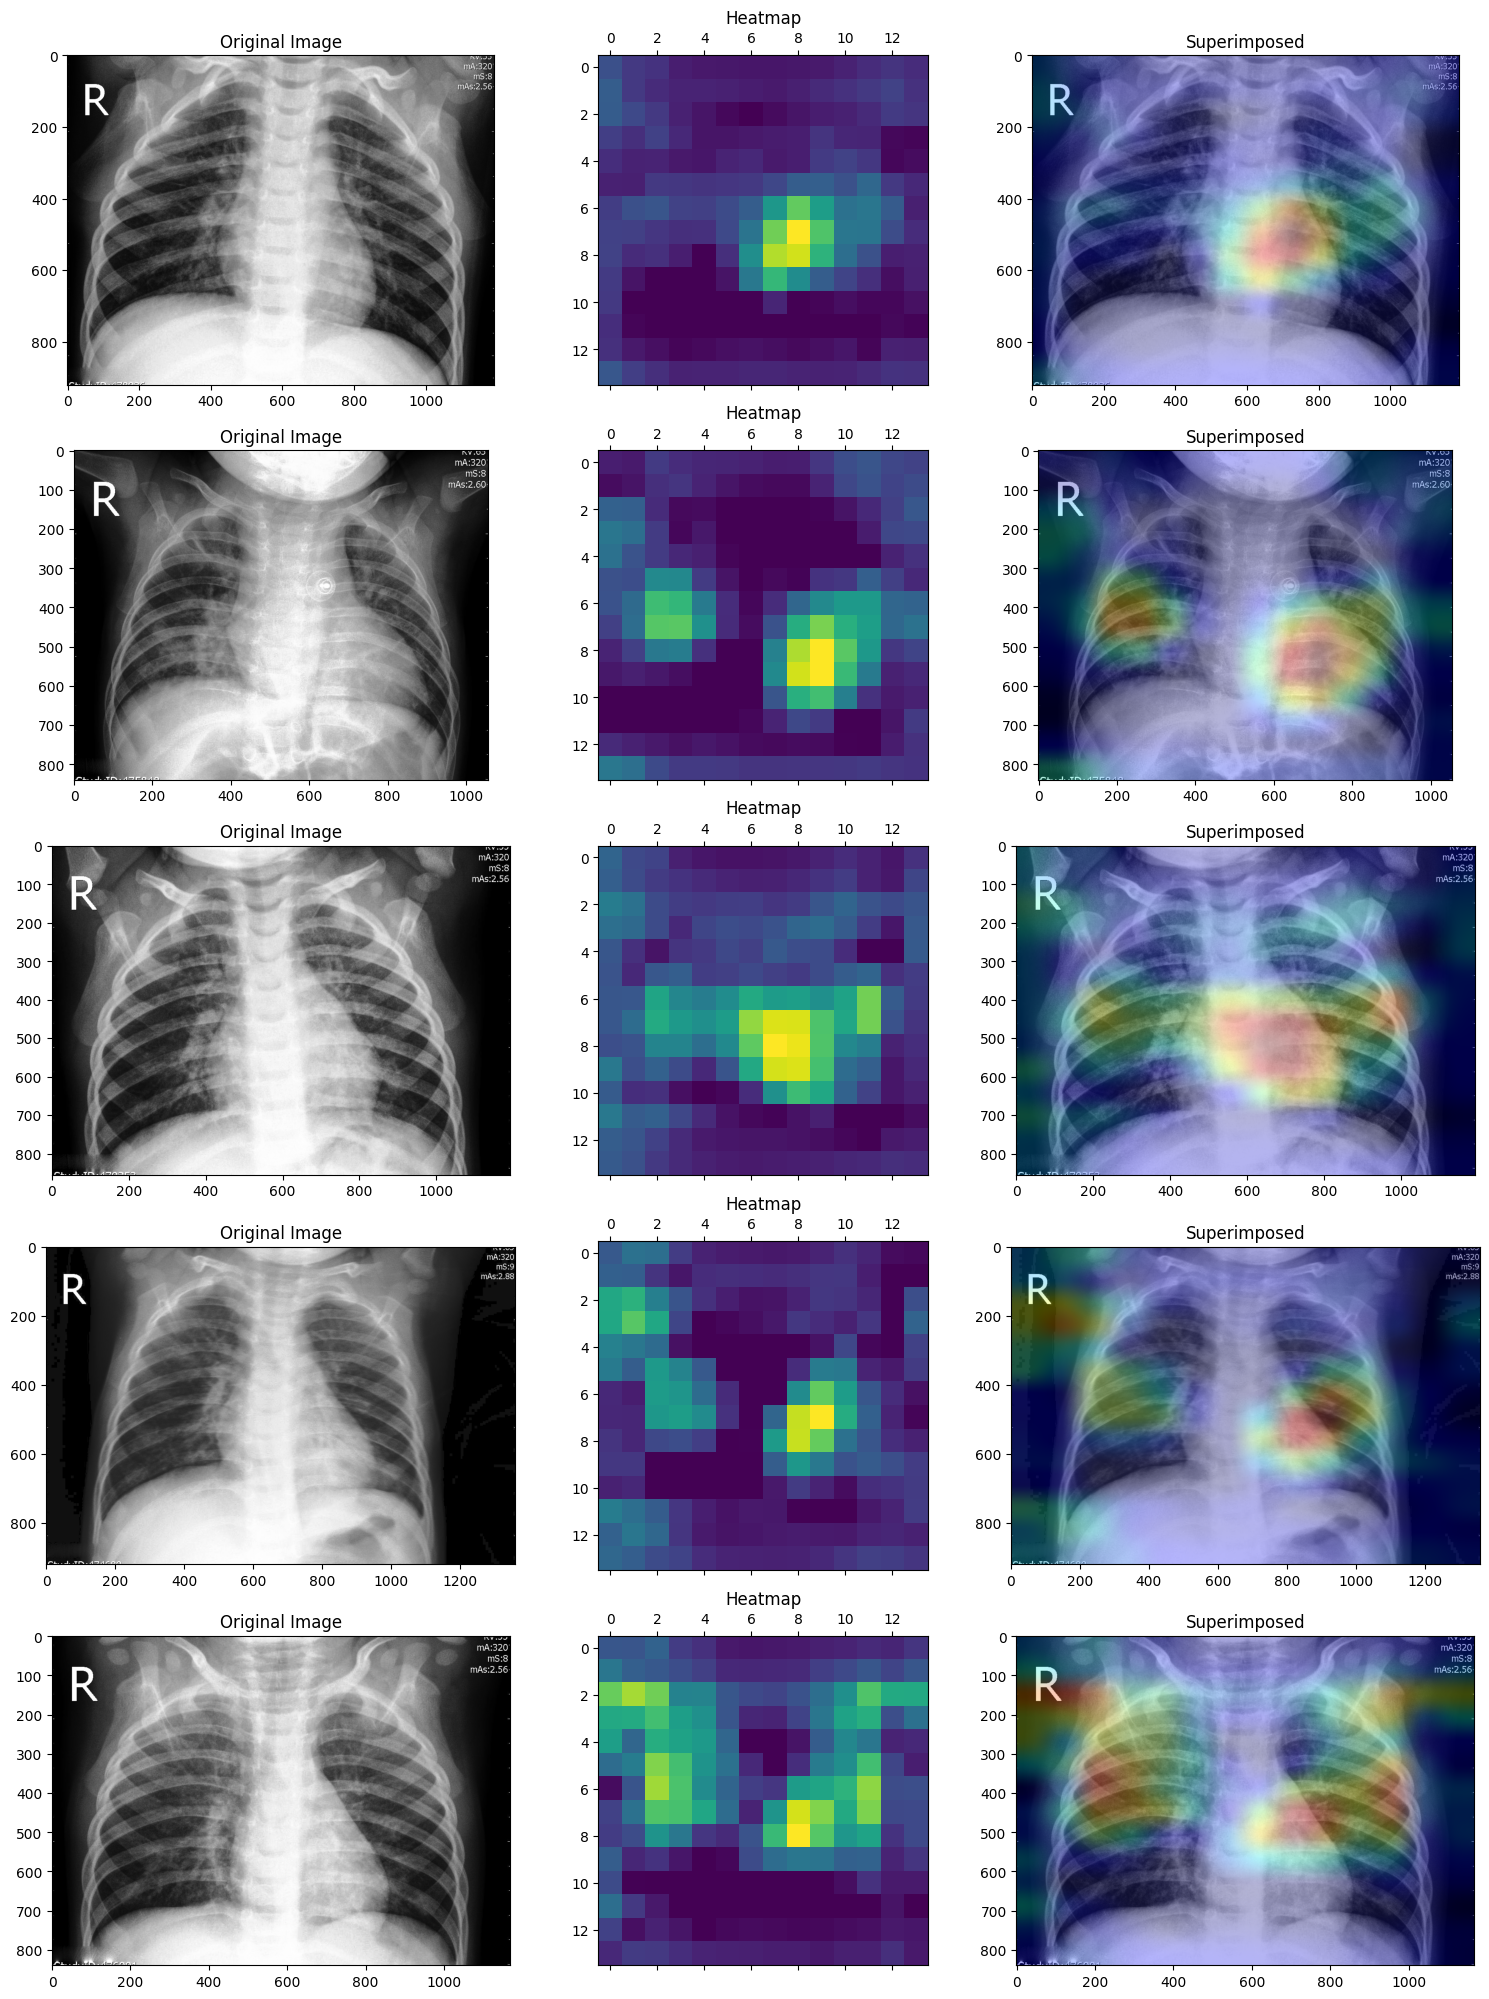

In [ ]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    #superimposed_img.save(cam_path)

    # Display Grad CAM
    #display(Image(cam_path))
    return superimposed_img

def preprocess_image(img_path):
    # טען את התמונה והמר אותה למערך (array) בגודל הרצוי
                img = cv2.imread(img_path)  # Read image using OpenCV

                #img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))  # שינוי גודל התמונה
                if img is None:
                  raise ValueError("לא ניתן לקרוא את התמונה")

                # חישוב היחס לשמירה על פרופורציות
                h, w = img.shape[:2]
                aspect = w / h

                # קביעת הגודל החדש תוך שמירה על היחס
                if aspect > 1:
                    # תמונה רחבה יותר
                    new_w = IMG_SIZE
                    new_h = int(new_w / aspect)
                else:
                    # תמונה גבוהה יותר
                    new_h = IMG_SIZE
                    new_w = int(new_h * aspect)

                # ביצוע ה-resize
                resized = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_CUBIC)

                # יצירת תמונה ריקה בגודל היעד
                final_img = np.zeros((IMG_SIZE, IMG_SIZE,3), dtype=np.uint8)

                # מיקום התמונה שעברה resize במרכז
                x_offset = (IMG_SIZE - new_w) // 2
                y_offset = (IMG_SIZE - new_h) // 2
                final_img[y_offset:y_offset+new_h, x_offset:x_offset+new_w] = resized

                final_img = cv2.GaussianBlur(final_img, (5, 5), 0)

                img = preprocess_input(final_img)  # עיבוד קלט עם




                img = np.array(img, dtype='float32')
                array = np.expand_dims(img, axis=0)
                return array


directory = train_dir+'/01/' # replace with the path to your directory
num_files_to_choose = 5

# get a list of all files in the directory
all_files = os.listdir(directory)

# randomly choose 5 files
chosen_files = random.sample(all_files, num_files_to_choose)

# create a list of the paths to the chosen files
file_paths = [os.path.join(directory, file) for file in chosen_files]
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

# assuming file_paths contains the paths to the 5 chosen files
fig, ax = plt.subplots(nrows=5, ncols=3, figsize=(15, 20))

for i, file_path in enumerate(file_paths):
    print(i , file_path)
    # read image and heatmap from file
    img = mpimg.imread(file_path)
    img_path = file_paths[i]
    img_array = (preprocess_image(img_path))
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    superimposed = save_and_display_gradcam(img_path, heatmap)

    # superimpose image and heatmap
    #alpha = 0.5 # adjust transparency of heatmap overlay
    #heatmap_overlay = np.dstack((np.zeros_like(heatmap), heatmap, np.zeros_like(heatmap))) * alpha
    #superimposed = img + heatmap_overlay

    # plot image, heatmap, and superimposed image
    ax[i, 0].imshow(img, cmap = 'gray')
    ax[i, 0].set_title("Original Image")
    ax[i, 1].imshow(heatmap, cmap="jet")
    ax[i, 1].matshow(heatmap)
    ax[i, 1].set_title("Heatmap")
    ax[i, 2].imshow(superimposed)
    ax[i, 2].set_title("Superimposed")

# adjust spacing between subplots
fig.tight_layout()

plt.show()

0 /content/gdrive/MyDrive/XRAY_Project//data//02/09.jpeg
צורת preds: (1, 3)
pred_index: tf.Tensor(1, shape=(), dtype=int64)
class_channel: tf.Tensor(7.021953, shape=(), dtype=float32)
predict:
tf.Tensor([-4.9068437   7.021953    0.86974126], shape=(3,), dtype=float32)


<ipython-input-49-4c399604bce7>:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


1 /content/gdrive/MyDrive/XRAY_Project//data//02/07.jpeg
צורת preds: (1, 3)
pred_index: tf.Tensor(1, shape=(), dtype=int64)
class_channel: tf.Tensor(5.169616, shape=(), dtype=float32)
predict:
tf.Tensor([-1.006954   5.169616  -0.7969085], shape=(3,), dtype=float32)
2 /content/gdrive/MyDrive/XRAY_Project//data//02/010.jpeg
צורת preds: (1, 3)
pred_index: tf.Tensor(1, shape=(), dtype=int64)
class_channel: tf.Tensor(4.6731467, shape=(), dtype=float32)
predict:
tf.Tensor([ 1.0095506  4.6731467 -3.740296 ], shape=(3,), dtype=float32)
3 /content/gdrive/MyDrive/XRAY_Project//data//02/01.jpeg
צורת preds: (1, 3)
pred_index: tf.Tensor(1, shape=(), dtype=int64)
class_channel: tf.Tensor(5.1781344, shape=(), dtype=float32)
predict:
tf.Tensor([ 1.777319   5.1781344 -4.140499 ], shape=(3,), dtype=float32)
4 /content/gdrive/MyDrive/XRAY_Project//data//02/082.jpeg
צורת preds: (1, 3)
pred_index: tf.Tensor(1, shape=(), dtype=int64)
class_channel: tf.Tensor(7.435121, shape=(), dtype=float32)
predict:
tf.Te

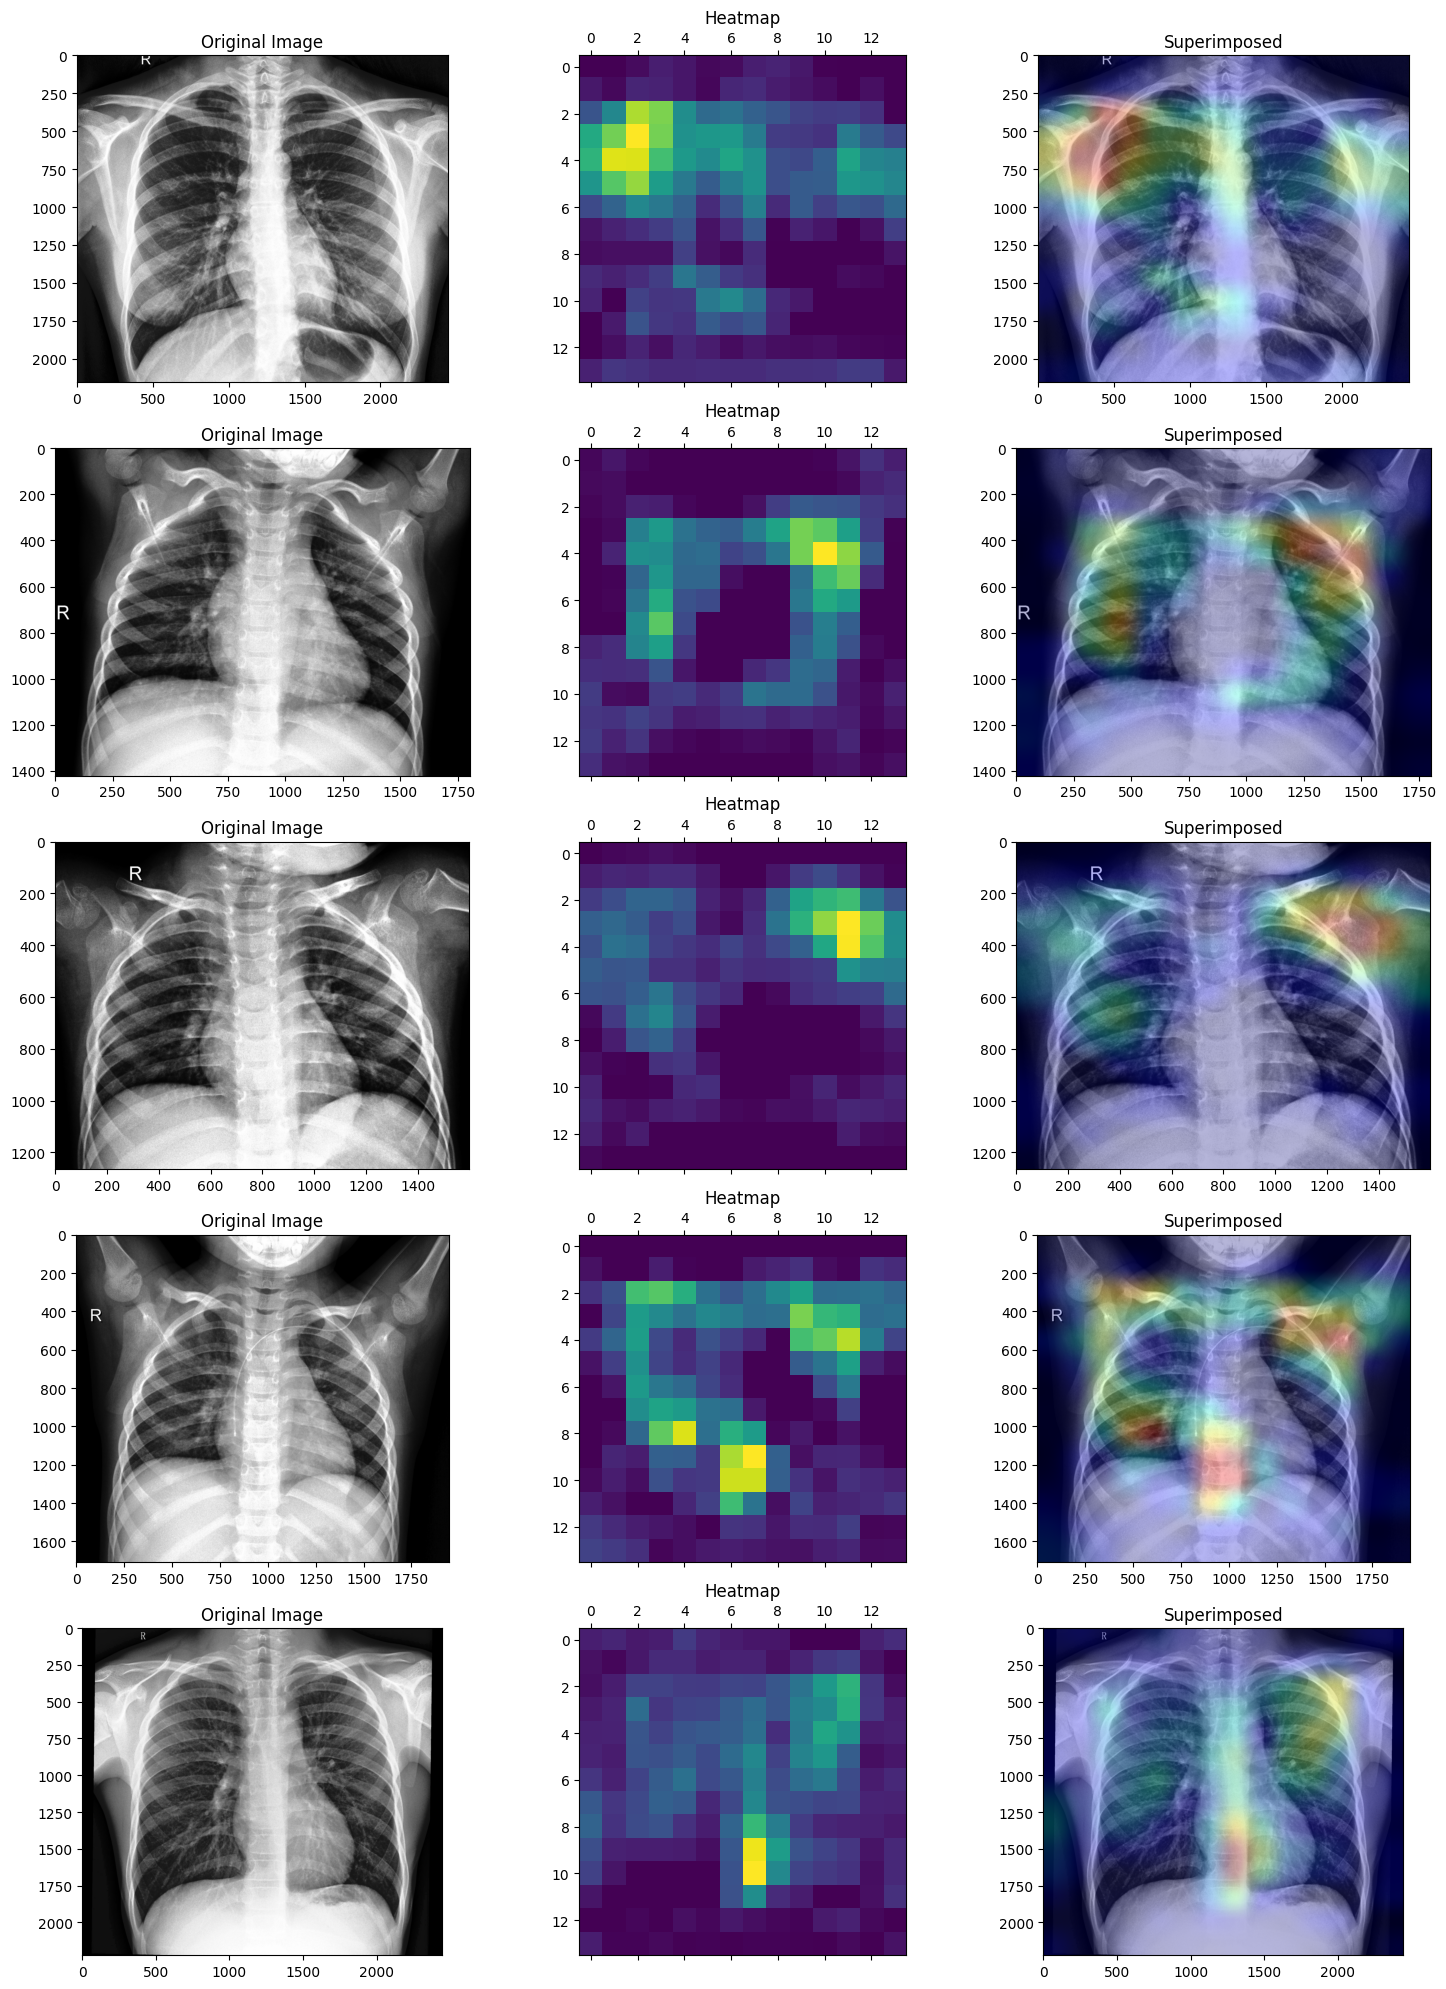

In [ ]:
directory = train_dir+'/02/' # replace with the path to your directory
num_files_to_choose = 5

# get a list of all files in the directory
all_files = os.listdir(directory)

# randomly choose 5 files
chosen_files = random.sample(all_files, num_files_to_choose)

# create a list of the paths to the chosen files
file_paths = [os.path.join(directory, file) for file in chosen_files]
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

# assuming file_paths contains the paths to the 5 chosen files
fig, ax = plt.subplots(nrows=5, ncols=3, figsize=(15, 20))

for i, file_path in enumerate(file_paths):
    print(i , file_path)
    # read image and heatmap from file
    img = mpimg.imread(file_path)
    img_path = file_paths[i]
    img_array = preprocess_image(img_path)
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    superimposed = save_and_display_gradcam(img_path, heatmap)

    # superimpose image and heatmap
    #alpha = 0.5 # adjust transparency of heatmap overlay
    #heatmap_overlay = np.dstack((np.zeros_like(heatmap), heatmap, np.zeros_like(heatmap))) * alpha
    #superimposed = img + heatmap_overlay

    # plot image, heatmap, and superimposed image
    ax[i, 0].imshow(img, cmap = 'gray')
    ax[i, 0].set_title("Original Image")
    ax[i, 1].imshow(heatmap, cmap="jet")
    ax[i, 1].matshow(heatmap)
    ax[i, 1].set_title("Heatmap")
    ax[i, 2].imshow(superimposed)
    ax[i, 2].set_title("Superimposed")

# adjust spacing between subplots
fig.tight_layout()

plt.show()

0 /content/gdrive/MyDrive/XRAY_Project//data//03/057.jpeg
צורת preds: (1, 3)
pred_index: tf.Tensor(2, shape=(), dtype=int64)
class_channel: tf.Tensor(8.863665, shape=(), dtype=float32)
predict:
tf.Tensor([-2.7884192 -3.3145964  8.863665 ], shape=(3,), dtype=float32)


<ipython-input-49-4c399604bce7>:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


1 /content/gdrive/MyDrive/XRAY_Project//data//03/COVID-00020.jpg
צורת preds: (1, 3)
pred_index: tf.Tensor(2, shape=(), dtype=int64)
class_channel: tf.Tensor(4.1030226, shape=(), dtype=float32)
predict:
tf.Tensor([ 0.02233527 -2.6465604   4.1030226 ], shape=(3,), dtype=float32)
2 /content/gdrive/MyDrive/XRAY_Project//data//03/085.jpeg
צורת preds: (1, 3)
pred_index: tf.Tensor(2, shape=(), dtype=int64)
class_channel: tf.Tensor(7.5770836, shape=(), dtype=float32)
predict:
tf.Tensor([-1.6112083 -4.4166484  7.5770836], shape=(3,), dtype=float32)
3 /content/gdrive/MyDrive/XRAY_Project//data//03/COVID-00029.jpg
צורת preds: (1, 3)
pred_index: tf.Tensor(2, shape=(), dtype=int64)
class_channel: tf.Tensor(6.5550833, shape=(), dtype=float32)
predict:
tf.Tensor([-2.8292618 -2.8993964  6.5550833], shape=(3,), dtype=float32)
4 /content/gdrive/MyDrive/XRAY_Project//data//03/01.jpeg
צורת preds: (1, 3)
pred_index: tf.Tensor(2, shape=(), dtype=int64)
class_channel: tf.Tensor(5.8128147, shape=(), dtype=flo

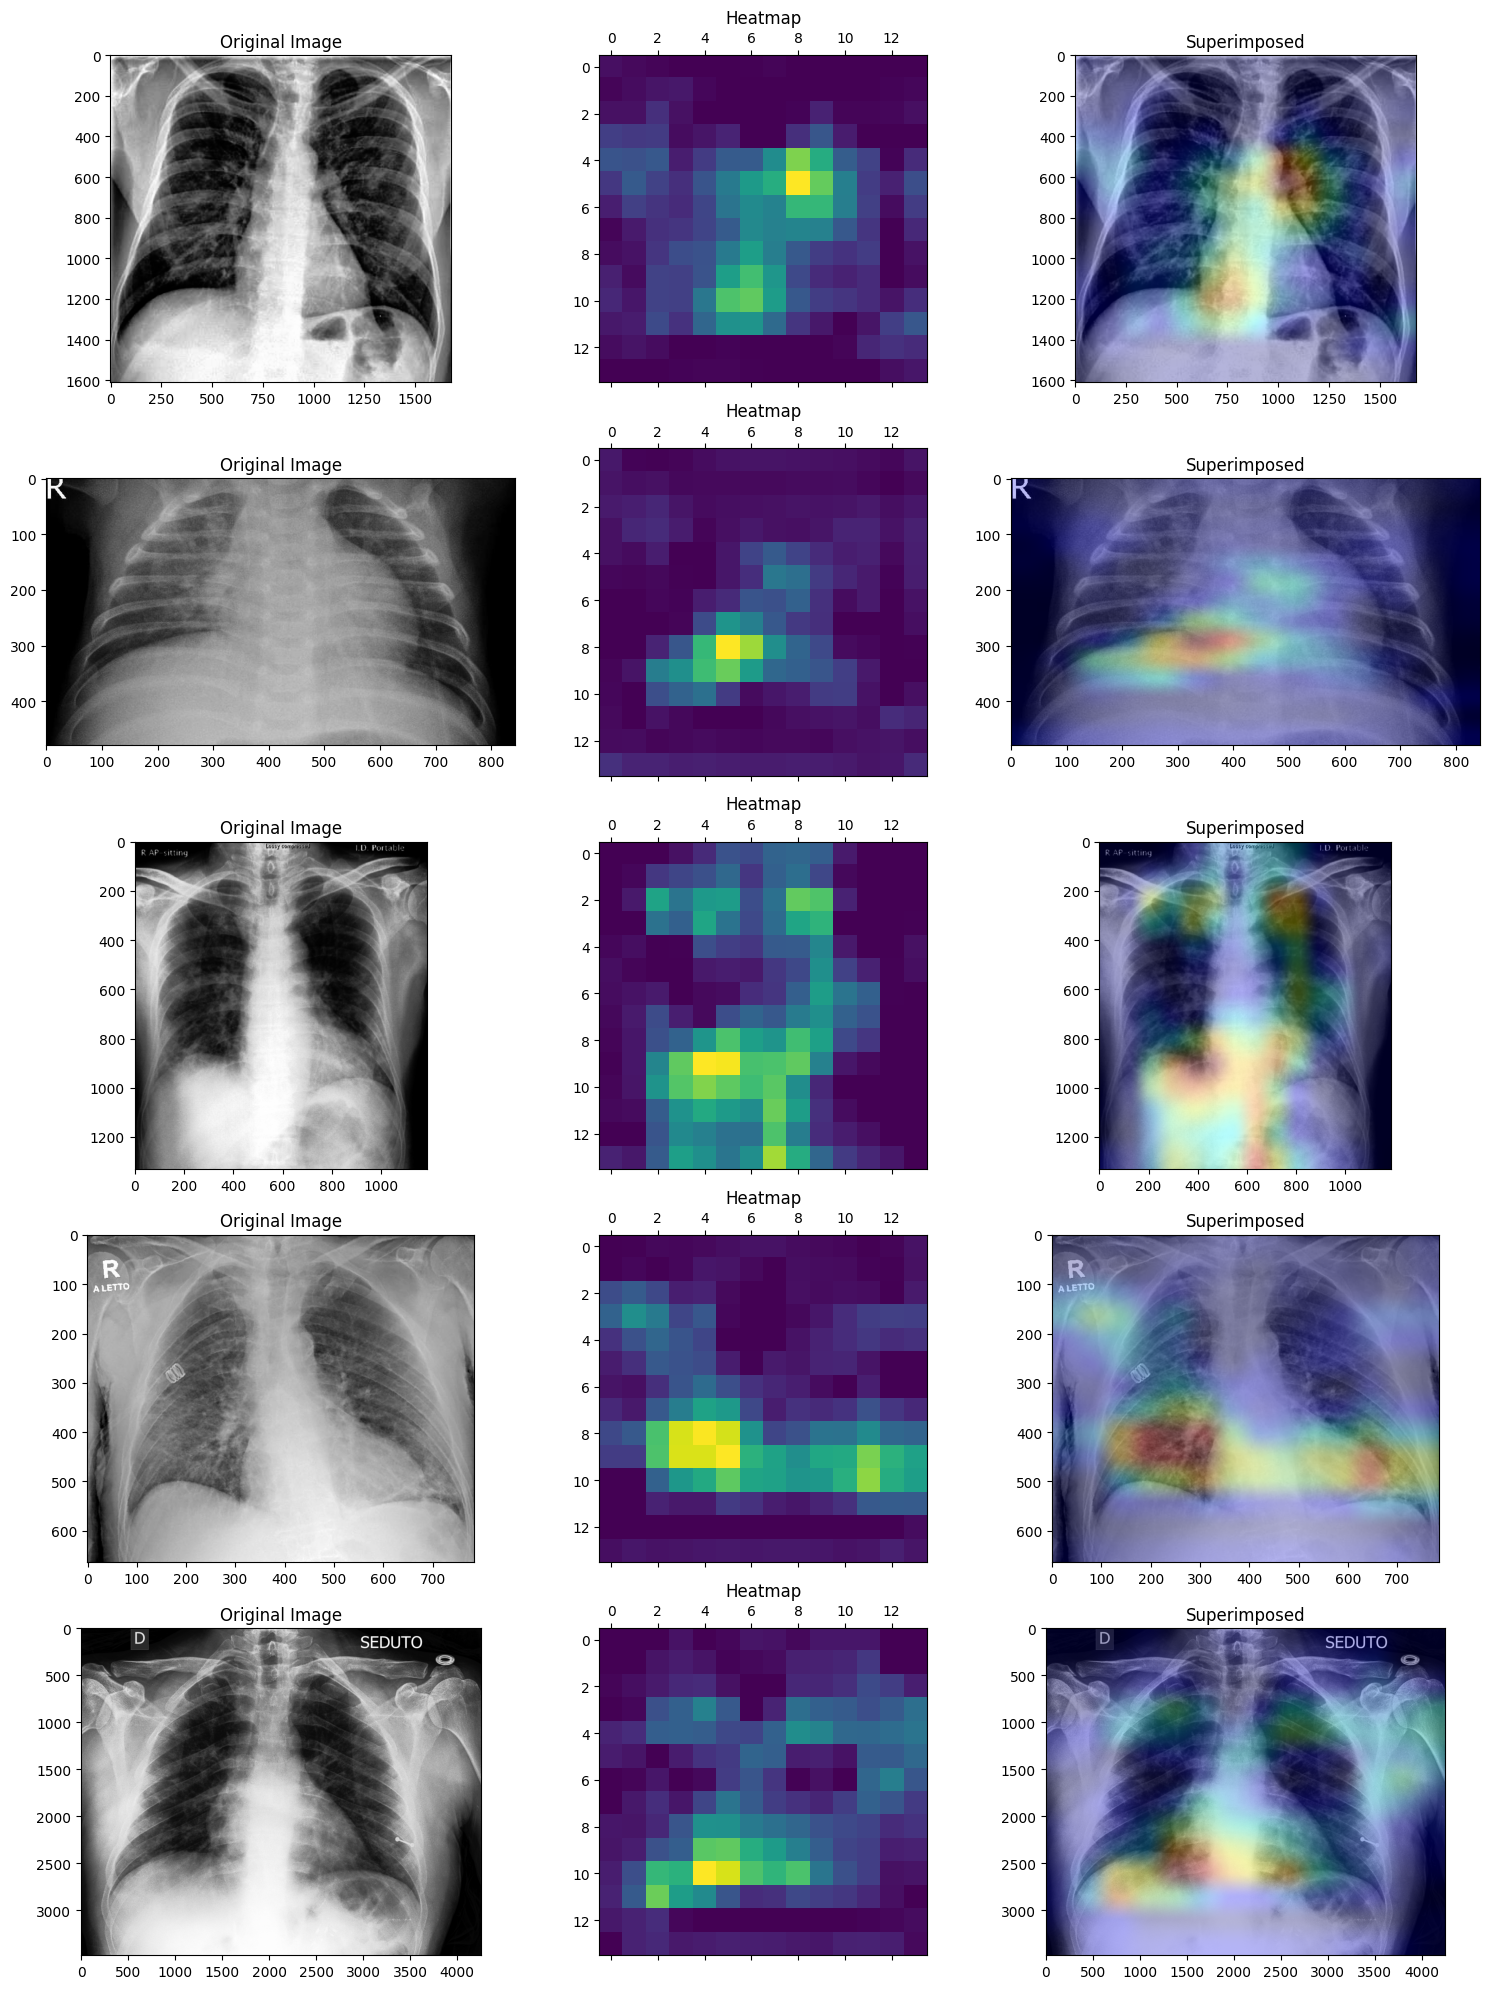

In [ ]:
directory = train_dir+'/03/' # replace with the path to your directory
num_files_to_choose = 5

# get a list of all files in the directory
all_files = os.listdir(directory)

# randomly choose 5 files
chosen_files = random.sample(all_files, num_files_to_choose)

# create a list of the paths to the chosen files
file_paths = [os.path.join(directory, file) for file in chosen_files]
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

# assuming file_paths contains the paths to the 5 chosen files
fig, ax = plt.subplots(nrows=5, ncols=3, figsize=(15, 20))

for i, file_path in enumerate(file_paths):
    print(i , file_path)
    # read image and heatmap from file
    img = mpimg.imread(file_path)
    img_path = file_paths[i]
    img_array = preprocess_image(img_path)
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    superimposed = save_and_display_gradcam(img_path, heatmap)

    # superimpose image and heatmap
    #alpha = 0.5 # adjust transparency of heatmap overlay
    #heatmap_overlay = np.dstack((np.zeros_like(heatmap), heatmap, np.zeros_like(heatmap))) * alpha
    #superimposed = img + heatmap_overlay

    # plot image, heatmap, and superimposed image
    ax[i, 0].imshow(img, cmap = 'gray')
    ax[i, 0].set_title("Original Image")
    ax[i, 1].imshow(heatmap, cmap="jet")
    ax[i, 1].matshow(heatmap)
    ax[i, 1].set_title("Heatmap")
    ax[i, 2].imshow(superimposed)
    ax[i, 2].set_title("Superimposed")

# adjust spacing between subplots
fig.tight_layout()

plt.show()